In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd



Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.
*italicised text*
You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

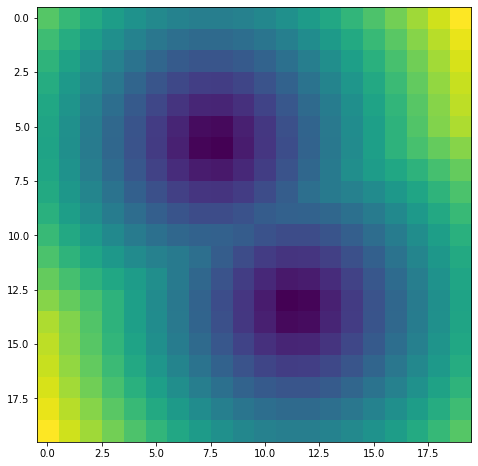


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

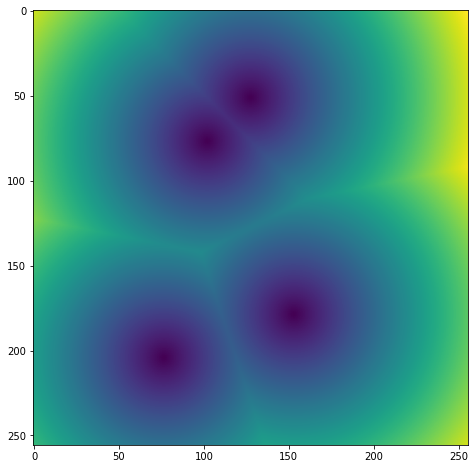


In [3]:
def min_dist(points, res):

  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """
  # Generate a grid of (x, y) coordinates
  x = torch.linspace(0, 1, res)
  y = torch.linspace(0, 1, res)
  grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

  # Stack the grid coordinates to shape (res, res, 2)
  grid = torch.stack((grid_x, grid_y), dim=-1)  # Shape: (res, res, 2)

  # Convert points to a tensor of shape (n, 2)
  points_tensor = torch.tensor(points).float()  # Shape: (n, 2)

  # Calculate squared distances to each point
  distances = torch.cdist(grid.reshape(-1, 2), points_tensor)  # Shape: (res*res, n)

  # Find the minimum distance for each pixel
  min_distances = distances.min(dim=1).values  # Shape: (res*res)

  # Reshape to (res, res)
  min_distances = min_distances.reshape(res, res)

  return min_distances

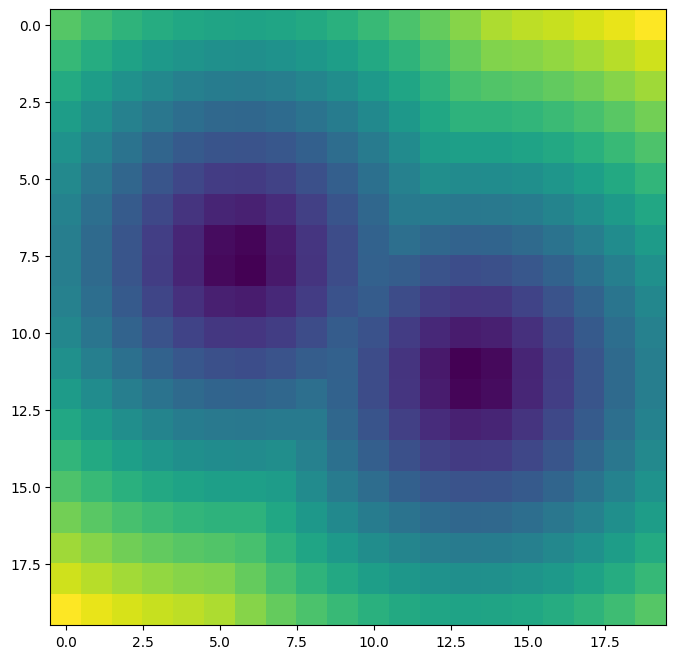

In [4]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

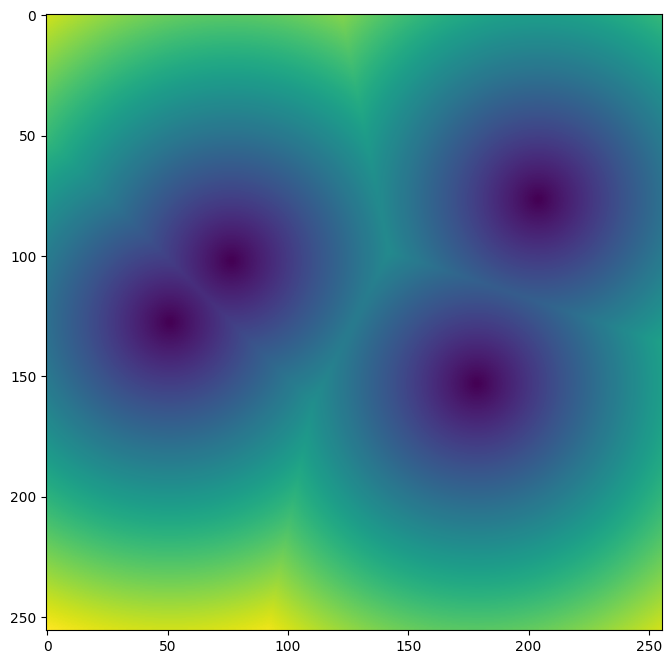

In [5]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

### Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [6]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  values = np.random.randint(0, 10, batch_size*num_points).reshape(batch_size, num_points)
  values = np.expand_dims(values, 2)
  points = np.concatenate((coords, values), axis=2)
  return points

In [7]:
def min_dist(points, res):
  """Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
              be in the range [0,1]. The expected shape is [B, P, 3].
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """
  batch_size, num_points, _ = points.shape

  # Create a grid of coordinates for the resolution
  grid_x, grid_y = np.meshgrid(
      np.linspace(0, 1, res), np.linspace(0, 1, res)
  )  # Shape: [res, res]
  grid = np.stack([grid_x, grid_y], axis=-1)  # Shape: [res, res, 2]

  # Expand the grid to match the batch size
  grid = np.expand_dims(grid, axis=0)  # Shape: [1, res, res, 2]
  grid = np.repeat(grid, batch_size, axis=0)  # Shape: [B, res, res, 2]

  # Initialize the distance tensor
  distance_tensor = np.full((batch_size, res, res), np.inf)

  # Calculate distances
  for b in range(batch_size):
      for p in range(num_points):
          point_coords = points[b, p, :2]  # Extract x, y of the point
          distances = np.sqrt(
              (grid[b, :, :, 0] - point_coords[0]) ** 2 +
              (grid[b, :, :, 1] - point_coords[1]) ** 2
          )
          # Update the minimum distances
          distance_tensor[b] = np.minimum(distance_tensor[b], distances)

  return distance_tensor

In [8]:
#Testing the function
batch_size = 3
num_points = 4

#Creating Points
points = create_points(batch_size, num_points)
print(points.shape)
res = 25  #resolution = 25
distances = min_dist(points, res)
print(distances.shape)

(3, 4, 3)
(3, 25, 25)


   Input :
  * points: a numpy array of 2D coordinates and point values, normalized to
    be in the range [0,1]. The expected shape is [B, P, 3].
  * res: the resolution of the output tensor.  
   
Returns:  
  * A (res x res) square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].  

While I used the shape [3, P, 3] and res as input and obtained the shape [3, 25, 25] as output which veifies the correctness of the function.


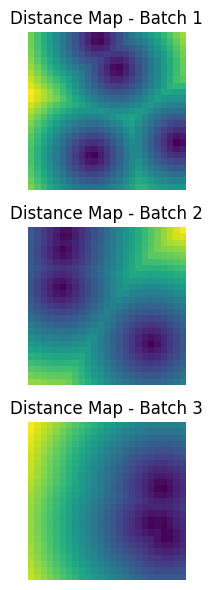

In [9]:
fig, axs = plt.subplots(batch_size, 1, figsize=(6, 6))
for i in range(batch_size):
    axs[i].imshow(distances[i], cmap='viridis')
    axs[i].set_title(f'Distance Map - Batch {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()